In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli

In [10]:
# Generates rewards matrix of size (2, ktrials, Nflies,precision)
# rb is a matrix of coeff_rs and zeros, and ry is a multiple of rb (the double if reward_quotient is set at 2)

def create_rewards(ktrials,Nflies,precision):
    r=np.random.randint(0,2,size=(ktrials,Nflies,precision))
    
    rb=coeff_r*r
    ry=reward_quotient*rb 
    
    rewards=np.asarray(np.empty((2,ktrials,Nflies,precision)))
    rewards[0]=rb
    rewards[1]=ry
    return (rewards)

In [11]:
# Generates choice array  of size (2,Nflies)

def choice (mb,my,beta):
    Py = np.exp(beta * my) / (np.exp(beta * my) + np.exp(beta * mb))
        
    cy = bernoulli.rvs(Py)
    cb = - cy +1
    return [cb,cy]

In [12]:
# Returns the estimated and effective rewards, and the energy spent.
# Respectively 2 arrays of size (Nflies,precision), an array of size (ktrials,Nflies,precision) and an array of size (Nflies,precision) 

def r_E_calcul(cb,cy,r_E_variables,rewards,i):
    r_E_variables["expected_rb"] = (1 - lambda_r * cb) * r_E_variables["expected_rb"] + lambda_r*rewards[0][i] * cb
    r_E_variables["expected_ry"] = (1 - lambda_r * cy) * r_E_variables["expected_ry"] + lambda_r*rewards[1][i] * cy
    
    r_E_variables["E"] = r_E_variables["E"] + (abs(r_E_variables["dmb"]) + abs(r_E_variables["dmy"]))*energy_factor
    
    r_E_variables["reward_received"][i] = rewards[0][i]*cb+rewards[1][i]*cy
      
    return[r_E_variables["expected_rb"],r_E_variables["expected_ry"],r_E_variables["reward_received"], r_E_variables["E"]]

In [21]:
# Generates an array of the mean rewards obtained, of size (2,precision)

def performance_energy(rewards, lambda_r, lambda_ARM):
    m_max=1
    x=1
    
    mean_random_r=150*coeff_r
    max_r=200*coeff_r
    
    beta = np.linspace(0,1000000,precision)
    
    mb = np.zeros((Nflies,precision))
    my = np.zeros((Nflies,precision))
    
    r_E_variables = { "expected_rb" : np.zeros((Nflies,precision)),
                    "expected_ry" : np.zeros((Nflies,precision)),
                    "reward_received" : np.empty((ktrials,Nflies,precision)),
                    "E" : np.zeros((Nflies,precision))}
    
    perf_E = np.empty((2,precision))
    
    for i in range (ktrials) :
        
        [cb,cy]=choice(mb,my,beta)
        
        mb -= mb * lambda_ARM
        r_E_variables["dmb"] = cb * eps * (rewards[0][i] - r_E_variables["expected_rb"]) * (x - mb/m_max)
        
        b_positive_correction=np.where(mb + r_E_variables["dmb"] < 0)
        r_E_variables["dmb"][b_positive_correction]= 0 - mb[b_positive_correction]
        
        b_max_correction=np.where(mb + r_E_variables["dmb"] > m_max)
        r_E_variables["dmb"][b_max_correction]= m_max - mb[b_max_correction]
        
        mb += r_E_variables["dmb"]
        
        my -= my * lambda_ARM
        r_E_variables["dmy"] = cy * eps * (rewards[1][i] - r_E_variables["expected_ry"]) * (x - my/m_max)
        
        y_positive_correction=np.where(my + r_E_variables["dmy"] < 0)
        r_E_variables["dmy"][y_positive_correction]= 0 - my[y_positive_correction]
        
        y_max_correction=np.where(my + r_E_variables["dmy"] > m_max)
        r_E_variables["dmy"][y_max_correction]= m_max - my[y_max_correction]
        
        my += r_E_variables["dmy"]
    
        [r_E_variables["expected_rb"],r_E_variables["expected_ry"],r_E_variables["reward_received"], r_E_variables["E"]]=r_E_calcul(cb,cy,r_E_variables,rewards,i)
    perf_E[0] = (sum(sum(r_E_variables["reward_received"]))/Nflies - mean_random_r)/(max_r-mean_random_r)
    perf_E[1] = sum(r_E_variables["E"])/Nflies
    return perf_E

In [29]:
# Parameters setting
Nflies = 100
ktrials = 200
lambda_r=0.1
coeff_r = 0.02
reward_quotient = 2
eps = 0.0001
energy_factor = 30
precision = 101

Text(0.5, 1.0, 'Mean performance for different values of beta')

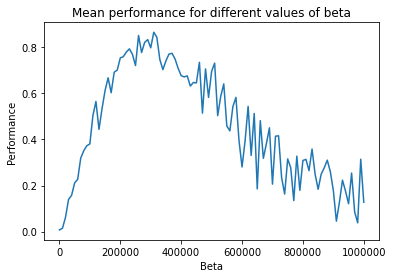

In [30]:
#Plot of the performance for different values of beta
plt.plot(performance_energy(create_rewards(ktrials,Nflies,precision), lambda_r, 0)[0])
plt.ylabel("Performance")
plt.xlabel("Beta")
plt.xticks([0,20,40,60,80,100], ["0", "200000", "400000", "600000", "800000", "1000000"])
plt.title("Mean performance for different values of beta")